# Multi-ConvNet Sentiment Classifier

 In this notebook, we concatenate the outputs of multiple, parallel convolutional layers to classify IMDB movie reviews by their sentiment.

### Load dependencies

In [2]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model # new!
from tensorflow.keras.layers import Input, concatenate # new! 
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 

### Set Hyperparameters

In [3]:
# output directory name :
output_dir = 'model_output/multiconv'

# Training :
epochs = 4
batch_size = 128

# Vector_space embedding:
n_dim = 64
n_unique_words = 5000
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2

# Convolutional layer Architecture:
n_conv_1 = n_conv_2 = n_conv_3 = 256
k_conv_1 = 3
k_conv_2 = 2
k_conv_3 = 4


# Dense layer Architecture :
n_dense = 256
dropout = 0.2

### Load Data

In [4]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

17464789/17464789 [==============================] - 1s 0us/step


### Preprocess Data

In [5]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

### Design Neural Network Architecture

In [6]:
input_layer = Input(shape=(max_review_length,),
                    dtype='int16', name='input')


# Embedding :
embedding_layer = Embedding(n_unique_words, n_dim, name='embedding') (input_layer)
drop_embed_layer = SpatialDropout1D(drop_embed, name='drop_embed')(embedding_layer)

# Three Parallel Convolutional Stream :
conv_1 = Conv1D(n_conv_1, k_conv_1, activation='relu', name='conv_1')(drop_embed_layer)
maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)

conv_2 = Conv1D(n_conv_2 , k_conv_2, activation='relu', name='conv_2')(drop_embed_layer)
maxp_2 = GlobalMaxPooling1D(name='maxp_2')(conv_2)

conv_3 = Conv1D(n_conv_3, k_conv_3, activation='relu', name='conv_3')(drop_embed_layer)
maxp_3 = GlobalMaxPooling1D(name='maxp_3')(conv_3)


# Concatenate The Activation from The Three Streams:
concat = concatenate([maxp_1, maxp_2, maxp_3])

# Dense Hidden Layer :
dense_layer =  Dense(n_dense, activation= 'relu', name='dense')(concat)
drop_dense_layer = Dropout(dropout, name='drop_dense')(dense_layer)

dense_2 = Dense(int(n_dense/4), activation='relu', name='dense_2') (drop_dense_layer)
dropout_2 = Dropout(dropout, name='drop_dense_2')(dense_2)

# Sigmoid output Layer:
predictions = Dense(1, activation='sigmoid', name='output')(dropout_2)


# Create Model :
model = Model(input_layer, predictions)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 400)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 400, 64)      320000      ['input[0][0]']                  
                                                                                                  
 drop_embed (SpatialDropout1D)  (None, 400, 64)      0           ['embedding[0][0]']              
                                                                                                  
 conv_1 (Conv1D)                (None, 398, 256)     49408       ['drop_embed[0][0]']             
                                                                                              

### Configure Model

In [8]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [9]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Train ! 

In [10]:
model.fit(x_train, y_train, batch_size=batch_size, epochs= epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 18s 45ms/step - loss: 0.4966 - accuracy: 0.7252 - val_loss: 0.2960 - val_accuracy: 0.8748
Epoch 2/4
196/196 [==============================] - 9s 44ms/step - loss: 0.2637 - accuracy: 0.8930 - val_loss: 0.2720 - val_accuracy: 0.8889
Epoch 3/4
196/196 [==============================] - 9s 47ms/step - loss: 0.1923 - accuracy: 0.9280 - val_loss: 0.2567 - val_accuracy: 0.8966
Epoch 4/4
196/196 [==============================] - 9s 44ms/step - loss: 0.1441 - accuracy: 0.9493 - val_loss: 0.2771 - val_accuracy: 0.8919


### Evaluate

In [14]:
model.load_weights(output_dir+"/weights.03.hdf5")

In [15]:
y_hat = model.predict(x_valid)

782/782 [==============================] - 3s 4ms/step


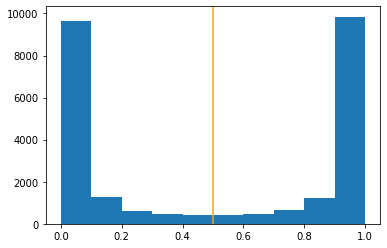

In [16]:
plt.hist(y_hat)
_= plt.axvline(x=0.5, color='orange')

In [17]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'96.24'